<a href="https://colab.research.google.com/github/OlamidotunT/Data-Analysis-and-Preparation-for-Predicting-Customer-Churn/blob/main/Data_Analysis_and_Customer_Churn_Prediction_Model_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

# Load the Excel file
excel_data = pd.read_excel('/content/Customer_Churn_Data_Large.xlsx', sheet_name=None)

# Check the sheet names
print(excel_data.keys())


dict_keys(['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status'])


In [4]:
import pandas as pd

# Load the Excel file and access all sheets
excel_data = pd.read_excel('/content/Customer_Churn_Data_Large.xlsx', sheet_name=None)

# Access each sheet using the sheet names
customer_demographics = excel_data['Customer_Demographics']
transaction_history = excel_data['Transaction_History']
customer_service = excel_data['Customer_Service']
online_activity = excel_data['Online_Activity']
churn_status = excel_data['Churn_Status']

# Check the first few rows of each sheet to get a sense of the data
print(customer_demographics.head())
print(transaction_history.head())
print(customer_service.head())
print(online_activity.head())
print(churn_status.head())


   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium
   CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
0           1           7194      2022-03-27       416.50     Electronics
1           2           7250      2022-08-08        54.96        Clothing
2           2           9660      2022-07-25       197.50     Electronics
3           2           2998      2022-01-25       101.31       Furniture
4           2           1228      2022-07-24       397.37        Clothing
   CustomerID  InteractionID InteractionDate InteractionType ResolutionStatus
0           1           6363      2022-03-31         Inquiry         Resolved
1           2           3329      2022-03-17         Inquiry         Resolved
2         

In [5]:
# Check for missing values in each sheet
print(customer_demographics.isnull().sum())
print(transaction_history.isnull().sum())
print(customer_service.isnull().sum())
print(online_activity.isnull().sum())
print(churn_status.isnull().sum())


CustomerID       0
Age              0
Gender           0
MaritalStatus    0
IncomeLevel      0
dtype: int64
CustomerID         0
TransactionID      0
TransactionDate    0
AmountSpent        0
ProductCategory    0
dtype: int64
CustomerID          0
InteractionID       0
InteractionDate     0
InteractionType     0
ResolutionStatus    0
dtype: int64
CustomerID        0
LastLoginDate     0
LoginFrequency    0
ServiceUsage      0
dtype: int64
CustomerID     0
ChurnStatus    0
dtype: int64


In [6]:
# One-hot encode categorical variables
customer_demographics = pd.get_dummies(customer_demographics, columns=['Gender', 'MaritalStatus', 'IncomeLevel'], drop_first=True)
transaction_history = pd.get_dummies(transaction_history, columns=['ProductCategory'], drop_first=True)
customer_service = pd.get_dummies(customer_service, columns=['InteractionType', 'ResolutionStatus'], drop_first=True)
online_activity = pd.get_dummies(online_activity, columns=['ServiceUsage'], drop_first=True)


In [7]:
# Convert 'LastLoginDate' and 'TransactionDate' to datetime
online_activity['LastLoginDate'] = pd.to_datetime(online_activity['LastLoginDate'])
transaction_history['TransactionDate'] = pd.to_datetime(transaction_history['TransactionDate'])

# Calculate 'days_since_last_login' and 'days_since_last_transaction'
today = pd.to_datetime('today')
online_activity['days_since_last_login'] = (today - online_activity['LastLoginDate']).dt.days
transaction_history['days_since_last_transaction'] = (today - transaction_history['TransactionDate']).dt.days


In [8]:
# Convert 'InteractionDate' to datetime
customer_service['InteractionDate'] = pd.to_datetime(customer_service['InteractionDate'])

# Calculate 'days_since_last_interaction'
customer_service['days_since_last_interaction'] = (today - customer_service['InteractionDate']).dt.days


In [9]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
customer_demographics[['Age']] = scaler.fit_transform(customer_demographics[['Age']])
transaction_history[['AmountSpent']] = scaler.fit_transform(transaction_history[['AmountSpent']])
online_activity[['LoginFrequency']] = scaler.fit_transform(online_activity[['LoginFrequency']])


In [10]:
# Merge all datasets by 'CustomerID'
df = customer_demographics.merge(transaction_history[['CustomerID', 'AmountSpent', 'days_since_last_transaction']], on='CustomerID', how='left') \
                           .merge(customer_service[['CustomerID', 'InteractionID', 'days_since_last_interaction']], on='CustomerID', how='left') \
                           .merge(online_activity[['CustomerID', 'LoginFrequency', 'days_since_last_login']], on='CustomerID', how='left') \
                           .merge(churn_status[['CustomerID', 'ChurnStatus']], on='CustomerID', how='left')

# Check the combined dataframe
print(df.head())


   CustomerID       Age  Gender_M  MaritalStatus_Married  \
0           1  1.229628      True                  False   
1           2  1.426547      True                   True   
2           2  1.426547      True                   True   
3           2  1.426547      True                   True   
4           2  1.426547      True                   True   

   MaritalStatus_Single  MaritalStatus_Widowed  IncomeLevel_Low  \
0                  True                  False             True   
1                 False                  False             True   
2                 False                  False             True   
3                 False                  False             True   
4                 False                  False             True   

   IncomeLevel_Medium  AmountSpent  days_since_last_transaction  \
0               False     1.165610                         1145   
1               False    -1.376208                         1011   
2               False    -0.374076 

In [11]:
df.describe()

,CustomerID,Age,AmountSpent,days_since_last_transaction,InteractionID,days_since_last_interaction,LoginFrequency,days_since_last_login,ChurnStatus
count,6812.000000,6812.000000,6812.000000,6812.000000,5204.000000,5204.000000,6812.000000,6812.000000,6812.000000
mean,500.169260,0.000493,0.006420,1048.908691,5921.861261,1048.311683,-0.013360,678.793893,0.198473
std,286.704642,1.003420,1.004675,104.690686,2332.331260,102.388679,1.000933,104.145325,0.398880
min,1.000000,-1.658518,-1.726188,866.000000,2015.000000,867.000000,-1.773232,501.000000,0.000000
25%,247.000000,-0.870842,-0.869025,958.000000,3873.250000,963.000000,-0.847894,592.000000,0.000000
50%,505.500000,0.048114,0.007998,1049.000000,5903.000000,1048.000000,0.006264,672.000000,0.000000
75%,750.000000,0.835790,0.875812,1139.000000,7851.000000,1134.000000,0.860422,764.000000,0.000000
max,1000.000000,1.689106,1.751675,1230.000000,9997.000000,1230.000000,1.643400,865.000000,1.000000


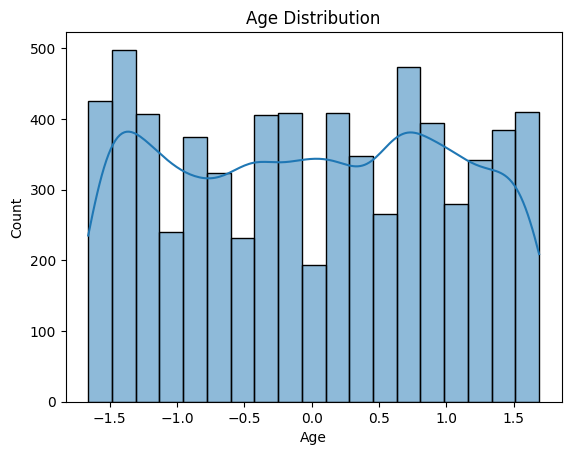

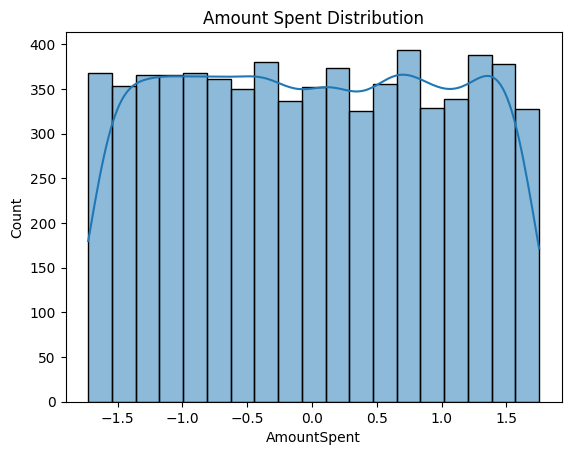

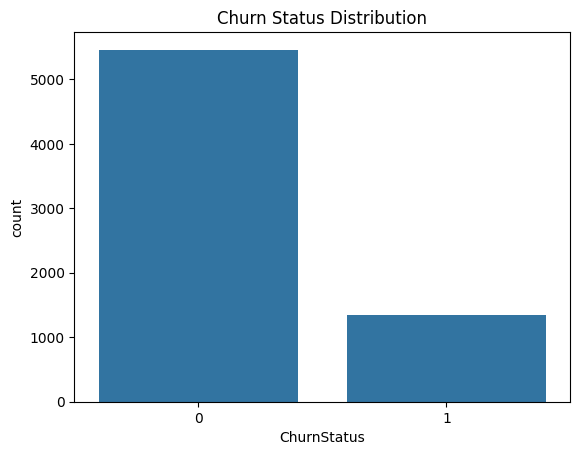

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize distribution of 'Age'
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Visualize distribution of 'AmountSpent'
sns.histplot(df['AmountSpent'], kde=True)
plt.title('Amount Spent Distribution')
plt.show()

# Visualize distribution of churn status
sns.countplot(x='ChurnStatus', data=df)
plt.title('Churn Status Distribution')
plt.show()


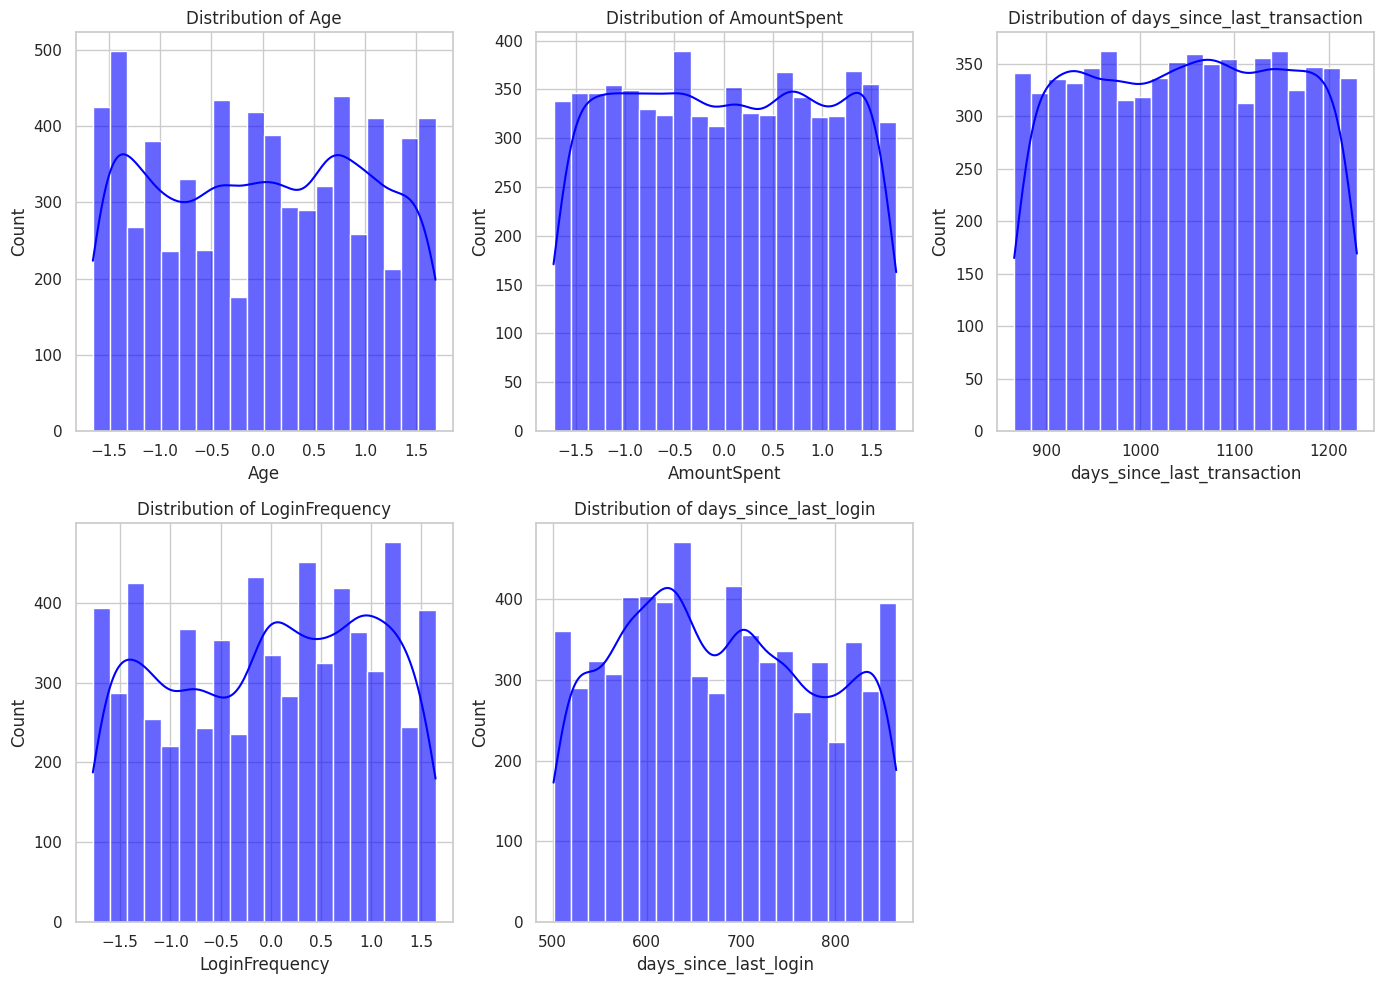

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
sns.set(style="whitegrid")

# List of numerical columns to explore
numerical_cols = ['Age', 'AmountSpent', 'days_since_last_transaction', 'LoginFrequency', 'days_since_last_login']

# Plot histograms for numerical features
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=20, color='blue', alpha=0.6)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()


<ipython-input-14-7cf20611a6a9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ChurnStatus', y=col, data=df, palette='Set2')
<ipython-input-14-7cf20611a6a9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ChurnStatus', y=col, data=df, palette='Set2')
<ipython-input-14-7cf20611a6a9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ChurnStatus', y=col, data=df, palette='Set2')
<ipython-input-14-7cf20611a6a9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` va

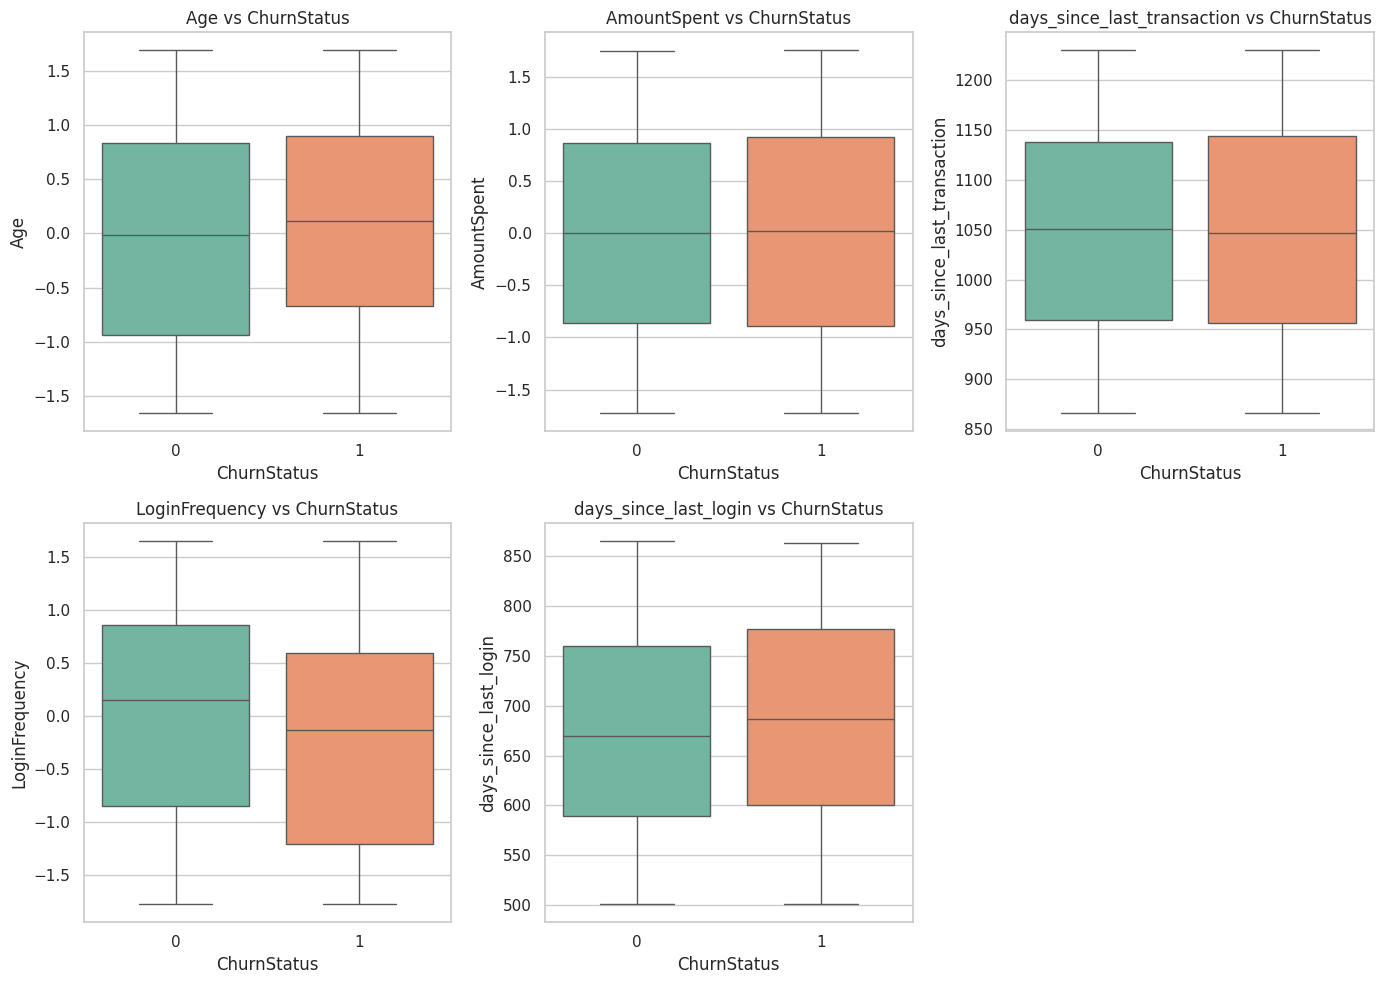

In [14]:
# Visualize the relationship between numerical features and ChurnStatus
plt.figure(figsize=(14, 10))

# For each numerical feature, plot boxplots for ChurnStatus
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='ChurnStatus', y=col, data=df, palette='Set2')
    plt.title(f'{col} vs ChurnStatus')
    plt.tight_layout()

plt.show()


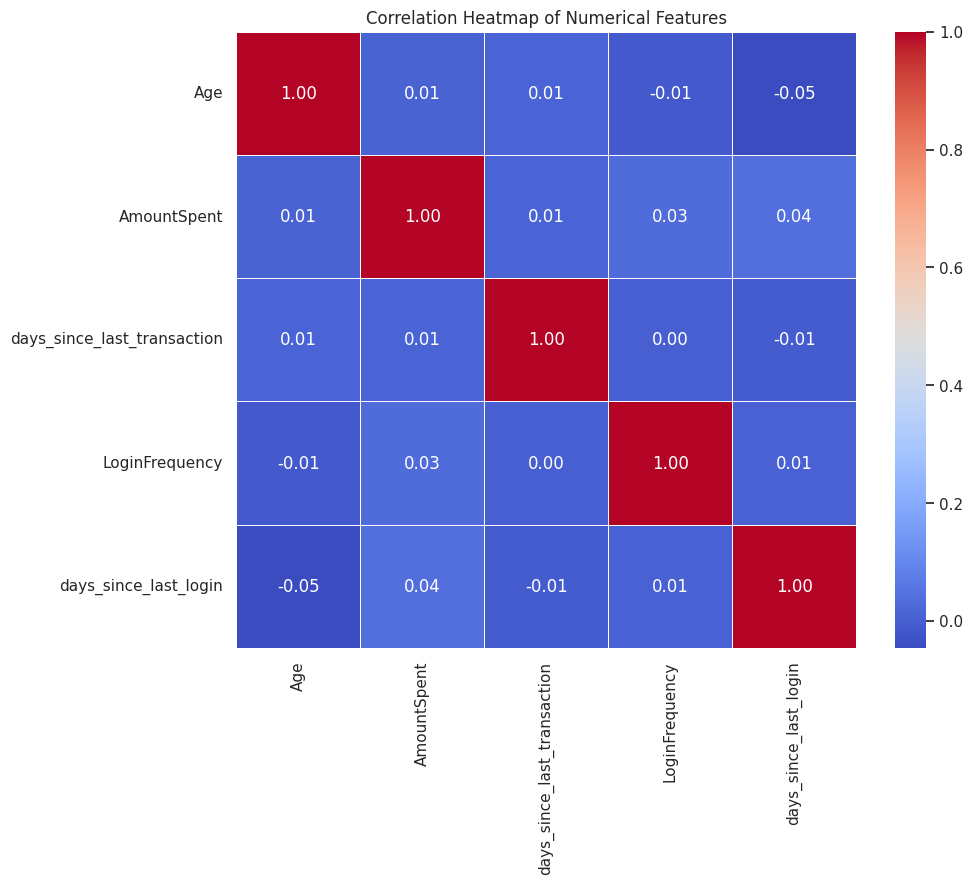

In [15]:
# Compute the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


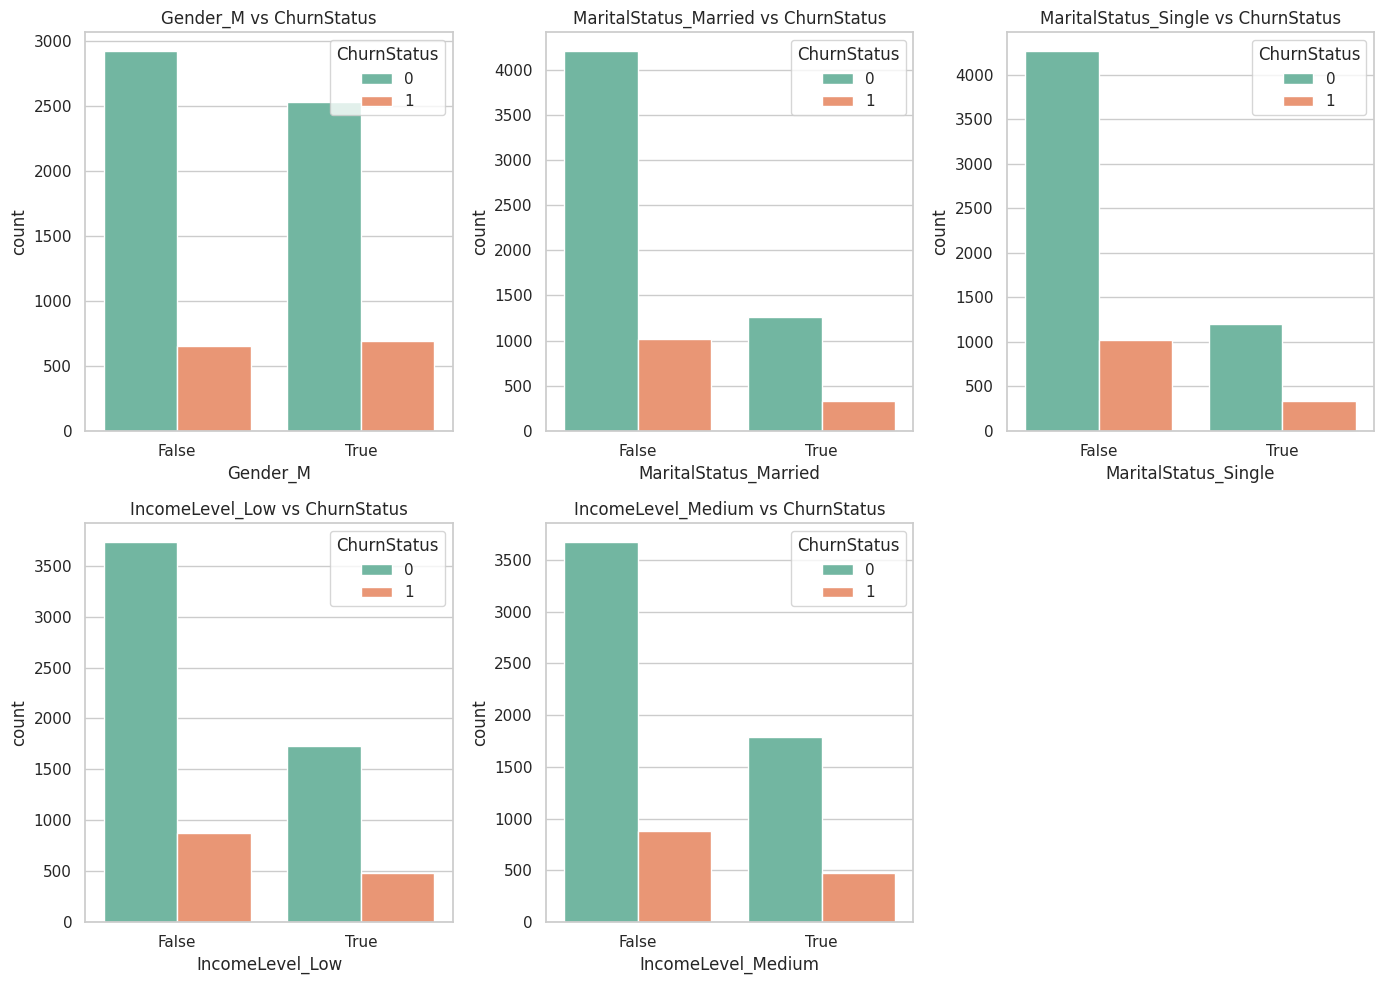

In [16]:
# Visualize the relationship between categorical features and ChurnStatus
categorical_cols = ['Gender_M', 'MaritalStatus_Married', 'MaritalStatus_Single',
                    'IncomeLevel_Low', 'IncomeLevel_Medium']

plt.figure(figsize=(14, 10))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, hue='ChurnStatus', data=df, palette='Set2')
    plt.title(f'{col} vs ChurnStatus')
    plt.tight_layout()

plt.show()


In [17]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# If any missing values are present, we can impute or remove them
# For simplicity, we will drop rows with missing values (if any) for now.
df_cleaned = df.dropna()


CustomerID                        0
Age                               0
Gender_M                          0
MaritalStatus_Married             0
MaritalStatus_Single              0
MaritalStatus_Widowed             0
IncomeLevel_Low                   0
IncomeLevel_Medium                0
AmountSpent                       0
days_since_last_transaction       0
InteractionID                  1608
days_since_last_interaction    1608
LoginFrequency                    0
days_since_last_login             0
ChurnStatus                       0
dtype: int64


In [18]:
# Handle missing values in 'InteractionID' and 'days_since_last_interaction'
max_days_since_last_interaction = df['days_since_last_interaction'].max()

df_cleaned['InteractionID'].fillna(0, inplace=True)  # Fill missing InteractionID with 0
df_cleaned['days_since_last_interaction'].fillna(max_days_since_last_interaction + 1, inplace=True)  # Fill with max days + 1

# Check if there are any remaining missing values
print(df_cleaned.isnull().sum())


CustomerID                     0
Age                            0
Gender_M                       0
MaritalStatus_Married          0
MaritalStatus_Single           0
MaritalStatus_Widowed          0
IncomeLevel_Low                0
IncomeLevel_Medium             0
AmountSpent                    0
days_since_last_transaction    0
InteractionID                  0
days_since_last_interaction    0
LoginFrequency                 0
days_since_last_login          0
ChurnStatus                    0
dtype: int64


<ipython-input-18-cb29e780cd3c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['InteractionID'].fillna(0, inplace=True)  # Fill missing InteractionID with 0
<ipython-input-18-cb29e780cd3c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['InteractionID'].fillna(0, inplace=True)  # Fill missing InteractionID with 0
<ipyt

In [19]:
df_cleaned

,CustomerID,Age,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,AmountSpent,days_since_last_transaction,InteractionID,days_since_last_interaction,LoginFrequency,days_since_last_login,ChurnStatus
0,1,1.229628,True,False,True,False,True,False,1.165610,1145,6363.0,1141.0,0.575702,572,0
1,2,1.426547,True,True,False,False,True,False,-1.376208,1011,3329.0,1155.0,-1.488513,527,1
2,2,1.426547,True,True,False,False,True,False,-0.374076,1025,3329.0,1155.0,-1.488513,527,1
3,2,1.426547,True,True,False,False,True,False,-1.050343,1206,3329.0,1155.0,-1.488513,527,1
4,2,1.426547,True,True,False,False,True,False,1.031116,1026,3329.0,1155.0,-1.488513,527,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6788,995,-1.330319,False,False,False,False,True,False,-0.174971,1153,9101.0,1109.0,0.575702,654,1
6789,995,-1.330319,False,False,False,False,True,False,1.716804,989,9101.0,1109.0,0.575702,654,1
6790,995,-1.330319,False,False,False,False,True,False,-1.051046,935,9101.0,1109.0,0.575702,654,1
6791,995,-1.330319,False,False,False,False,True,False,-1.242979,940,9101.0,1109.0,0.575702,654,1


In [20]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Columns to scale
scale_cols = ['Age', 'AmountSpent', 'days_since_last_transaction',
              'LoginFrequency', 'days_since_last_login']

# Apply scaling
df_cleaned[scale_cols] = scaler.fit_transform(df_cleaned[scale_cols])

# Check the transformed dataset
print(df_cleaned.head())


   CustomerID       Age  Gender_M  MaritalStatus_Married  \
0           1  1.222379      True                  False   
1           2  1.416820      True                   True   
2           2  1.416820      True                   True   
3           2  1.416820      True                   True   
4           2  1.416820      True                   True   

   MaritalStatus_Single  MaritalStatus_Widowed  IncomeLevel_Low  \
0                  True                  False             True   
1                 False                  False             True   
2                 False                  False             True   
3                 False                  False             True   
4                 False                  False             True   

   IncomeLevel_Medium  AmountSpent  days_since_last_transaction  \
0               False     1.131382                     0.903001   
1               False    -1.391297                    -0.379422   
2               False    -0.396711 

<ipython-input-20-bed9770774d4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[scale_cols] = scaler.fit_transform(df_cleaned[scale_cols])


In [21]:
from sklearn.model_selection import train_test_split

# Define the feature matrix X and target vector y
X = df_cleaned.drop(columns=['ChurnStatus', 'CustomerID', 'InteractionID'])  # drop target and non-feature columns
y = df_cleaned['ChurnStatus']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the train-test split
print(f'Training set shape: {X_train.shape}, Test set shape: {X_test.shape}')


Training set shape: (4163, 12), Test set shape: (1041, 12)


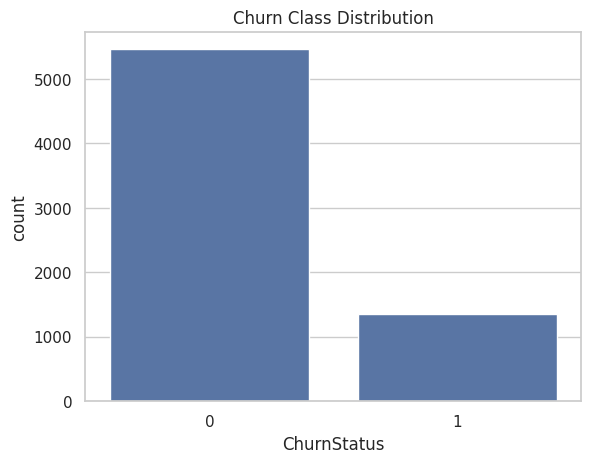

ChurnStatus
0    0.801527
1    0.198473
Name: proportion, dtype: float64


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot
sns.countplot(x='ChurnStatus', data=df)
plt.title('Churn Class Distribution')
plt.show()

# Print class distribution
print(df['ChurnStatus'].value_counts(normalize=True))


In [23]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_cleaned.drop(columns=['ChurnStatus', 'CustomerID'])  # Drop ID and target
y = df_cleaned['ChurnStatus']

# First split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# Second split: 50% of temp goes to val, 50% to test => each gets 15% of total
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5,
                                                stratify=y_temp,
                                                random_state=42)

# Check the distribution
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Training set: 3642
Validation set: 781
Test set: 781


In [29]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training set only
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))



Before SMOTE: Counter({0: 2892, 1: 750})
After SMOTE: Counter({0: 2892, 1: 2892})


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=42,
                                  class_weight=None)  # SMOTE already handled class imbalance

# Fit the model
rf_model.fit(X_train_smote, y_train_smote)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)
y_val_proba = rf_model.predict_proba(X_val)[:, 1]  # For ROC-AUC

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_val_proba))


Confusion Matrix:
 [[618   2]
 [  7 154]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       620
           1       0.99      0.96      0.97       161

    accuracy                           0.99       781
   macro avg       0.99      0.98      0.98       781
weighted avg       0.99      0.99      0.99       781

ROC-AUC Score: 0.9968292927269085


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming model is called `model_rf` and it has already been fitted
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


<ipython-input-33-6048a8815d52>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(15), x='Importance', y='Feature', palette='viridis')


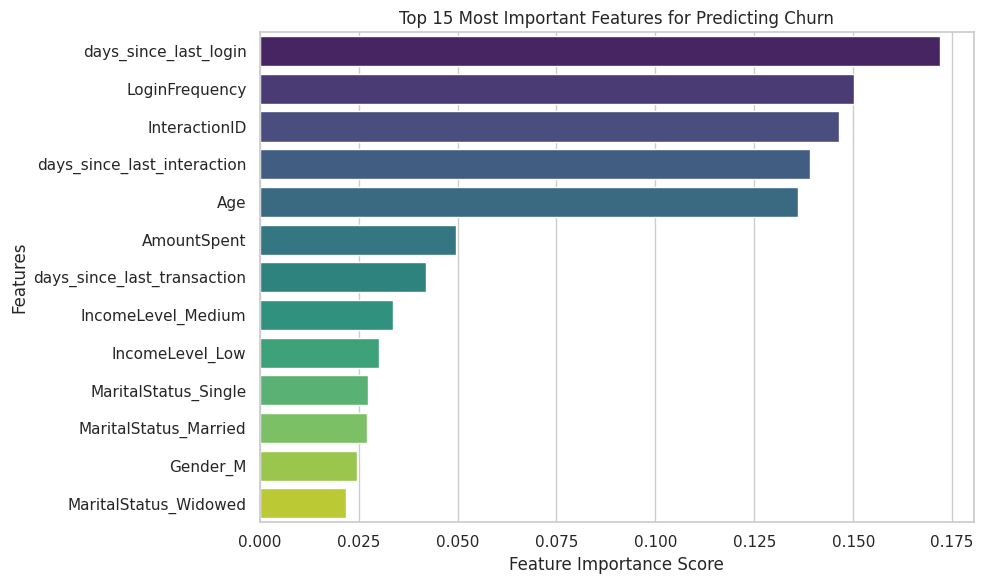

In [33]:
# Plot top 15 important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Most Important Features for Predicting Churn')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [34]:
feature_importances


,Feature,Importance
12,days_since_last_login,0.171929
11,LoginFrequency,0.150086
9,InteractionID,0.146470
10,days_since_last_interaction,0.139094
0,Age,0.135975
7,AmountSpent,0.049573
8,days_since_last_transaction,0.042072
6,IncomeLevel_Medium,0.033636
5,IncomeLevel_Low,0.030122
3,MaritalStatus_Single,0.027319


In [38]:
# Convert SMOTE output back to a DataFrame with the original column names
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)


In [39]:
import shap

# Create TreeExplainer and compute SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_smote)


<Figure size 640x480 with 0 Axes>

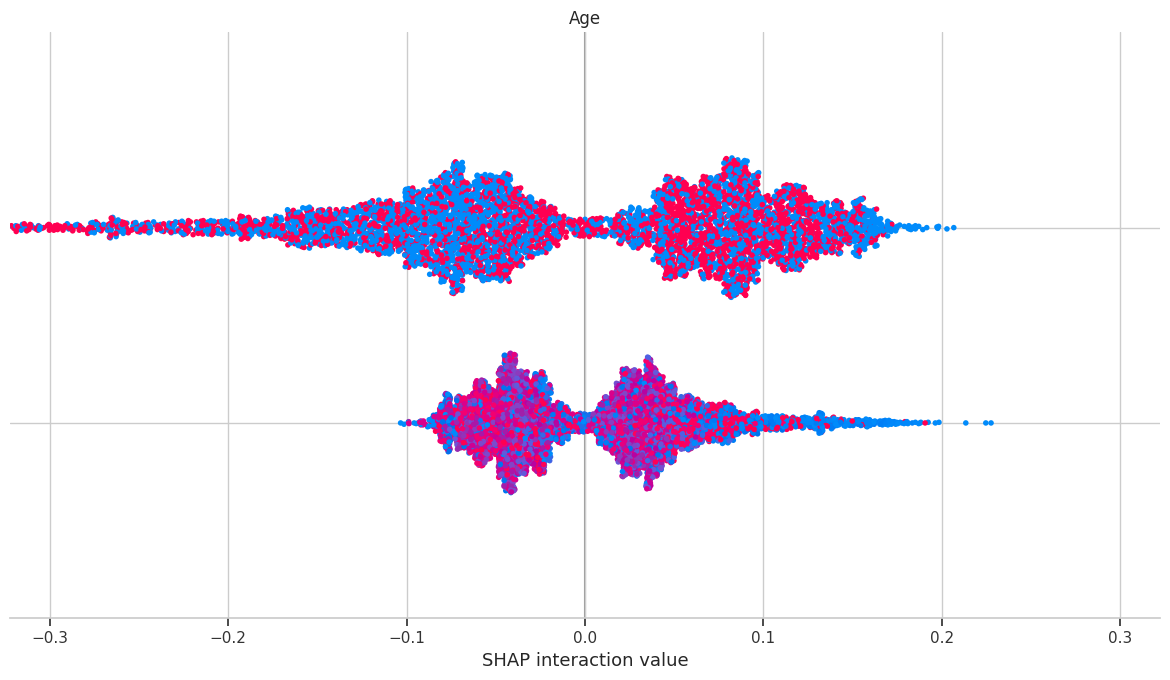

In [42]:
shap.summary_plot(shap_values, X_train_smote, plot_type="bar")



In [41]:
print("SHAP values shape:", shap_values[1].shape)
print("X_train_smote shape:", X_train_smote.shape)
print("X_train_smote columns:", X_train_smote.columns.tolist())


SHAP values shape: (13, 2)
X_train_smote shape: (5784, 13)
X_train_smote columns: ['Age', 'Gender_M', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widowed', 'IncomeLevel_Low', 'IncomeLevel_Medium', 'AmountSpent', 'days_since_last_transaction', 'InteractionID', 'days_since_last_interaction', 'LoginFrequency', 'days_since_last_login']


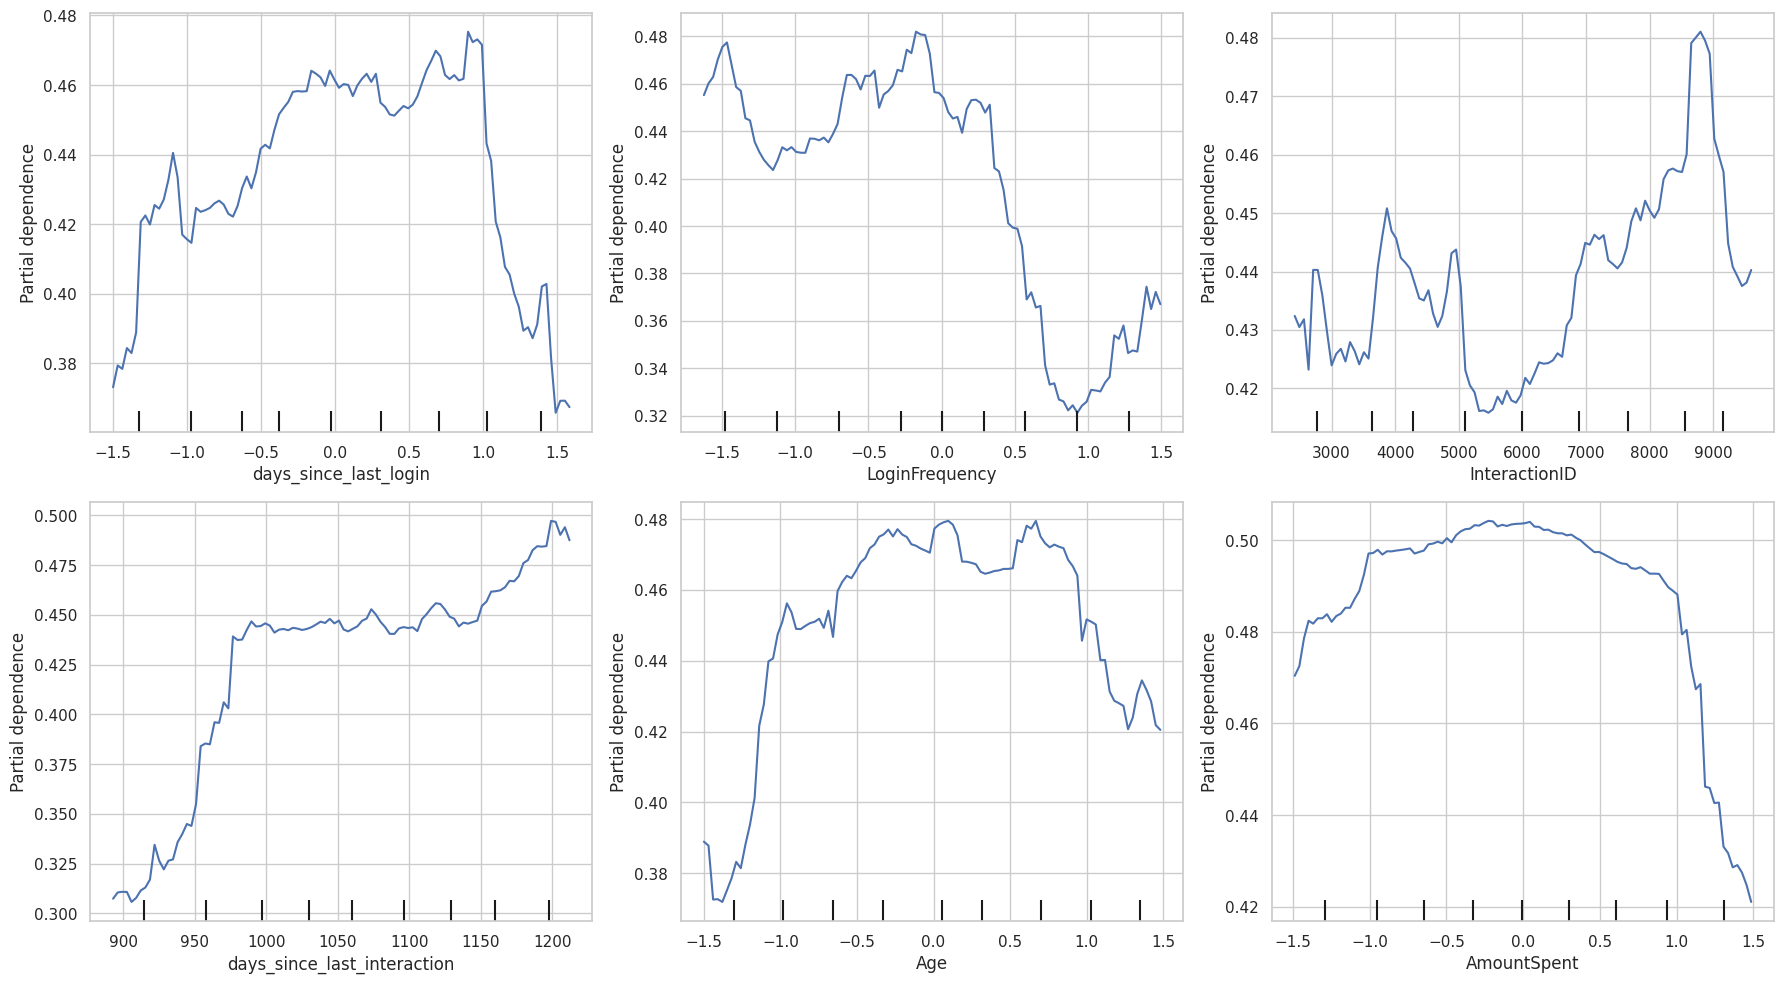

In [43]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List of top features (based on SHAP or feature importance)
top_features = [
    'days_since_last_login',
    'LoginFrequency',
    'InteractionID',
    'days_since_last_interaction',
    'Age',
    'AmountSpent'
]

# Create partial dependence plots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten axes for easy iteration
ax = ax.flatten()

# Plot PDP for each top feature
for i, feature in enumerate(top_features):
    PartialDependenceDisplay.from_estimator(rf_model, X_train_smote, [feature], ax=ax[i])

plt.tight_layout()
plt.show()


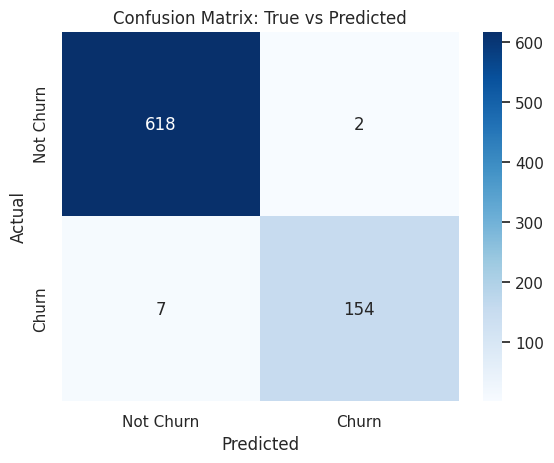

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on validation or test set
y_pred = rf_model.predict(X_val)

# Create a confusion matrix plot
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: True vs Predicted")
plt.show()


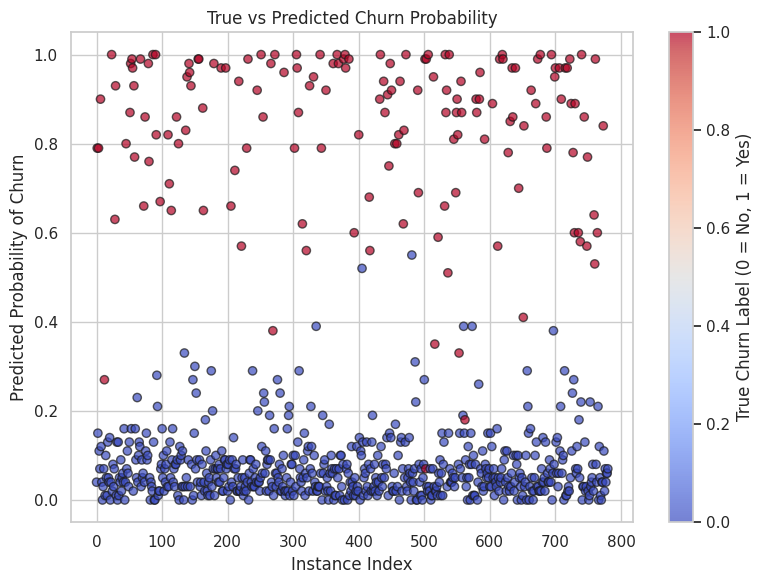

In [47]:
import matplotlib.pyplot as plt

# Predict probabilities for class 1 (churn)
y_proba = rf_model.predict_proba(X_val)[:, 1]

# Plot: True labels vs. Predicted probabilities
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_val)), y_proba, c=y_val, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel("Instance Index")
plt.ylabel("Predicted Probability of Churn")
plt.title("True vs Predicted Churn Probability")
plt.colorbar(label='True Churn Label (0 = No, 1 = Yes)')
plt.grid(True)
plt.tight_layout()
plt.show()
